In [2]:
import cv2
import os
import numpy as np
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
# Define the path to your directory
directory = r'C:\Users\nandu\data\test'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = np.array([cv2.imread(img_path) for img_path in image_paths])

pmw=[]
ir=[]
# cv2.imshow('image',images[0])
for i in range(len(images)):
    image1 = images[i][0:201, 0:201,:]
    image2 = images[i][0:201,201:402,:]
    image1=cv2.resize(image1,(256,256))
    image2=cv2.resize(image2,(256,256))
    image1=image1.reshape(256,256,3)
    image2=image2.reshape(256,256,3)
    pmw.append(image1)
    ir.append(image2)
pmw=np.array(pmw)
ir=np.array(ir)
print(pmw.shape)
# Now `images` is a list of numpy arrays representing your images in grayscale
dataA = vstack((pmw,pmw))
dataB = vstack((ir,ir))
print('Loaded dataA: ', dataA.shape)
print('Loaded dataB: ', dataB.shape)
# # save as compressed numpy array
filename = 'pmwtoir_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

(5, 256, 256, 3)
Loaded dataA:  (10, 256, 256, 3)
Loaded dataB:  (10, 256, 256, 3)
Saved dataset:  pmwtoir_256.npz


Loaded:  (10, 256, 256, 3) (10, 256, 256, 3)


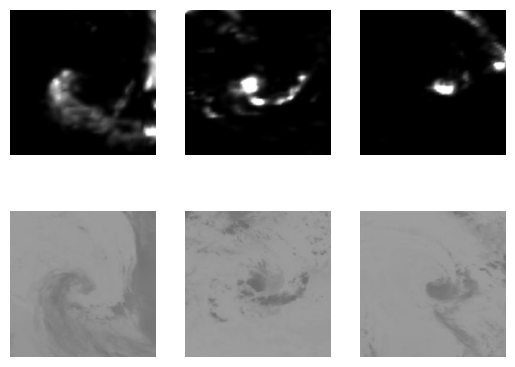

In [3]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('pmwtoir_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [4]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	trainA, trainB = dataset
	n_epochs, n_batch, = 1,1
	# determine the output squartre shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

# load image data
dataset = load_real_samples('pmwtoir_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (10, 256, 256, 3) (10, 256, 256, 3)



c:\Users\nandu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 3s 3s/step



>1, dA[1.348,4.563] dB[0.817,15.572] g[18.664,23.733]
1/1 [==============================] - 1s 1s/step
>2, dA[28.888,94.175] dB[73.986,13.763] g[104.263,53.968]
1/1 [==============================] - 2s 2s/step
>3, dA[24.071,9.348] dB[11.591,2.588] g[30.802,81.808]
1/1 [==============================] - 2s 2s/step
>4, dA[4.193,3.213] dB[8.252,0.980] g[20.411,22.545]
1/1 [==============================] - 2s 2s/step
>5, dA[0.891,0.828] dB[1.242,0.362] g[14.426,17.437]
1/1 [==============================] - 2s 2s/step
>6, dA[0.734,0.231] dB[0.403,0.410] g[12.580,16.170]
1/1 [==============================] - 2s 2s/step
>7, dA[0.402,0.348] dB[0.438,0.259] g[12.148,14.735]
1/1 [==============================] - 2s 2s/step
>8, dA[0.325,0.210] dB[0.106,0.137] g[11.524,14.404]
1/1 [==============================] - 2s 2s/step
>9, dA[0.330,0.207] dB[0.178,0.131] g[11.659,14.706]
1/1 [==============================] - 1s 1s/step
>10, dA[0.230,0.247] dB[0.245,0.120] g[11.611,14.663]
1/1 [======

In [4]:
# load dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
A_data, B_data = load_real_samples('pmwtoir_256.npz')
print('Loaded', A_data.shape, B_data.shape)


Loaded (10, 256, 256, 3) (10, 256, 256, 3)


In [5]:

...
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_089025.h5', cust)
model_BtoA = load_model('g_model_BtoA_089025.h5', cust)

NameError: name 'load_model' is not defined